# An example of masterplan creation

In [1]:
import os

os.environ['USE_PYGEOS'] = os.environ.get('USE_PYGEOS', '0')
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
from IPython.display import Image, Markdown, display

from masterplan_tools.method import MasterPlan, balance_data
from masterplan_tools.method.provision import ProvisionModel
from masterplan_tools.models import CityModel
from masterplan_tools.preprocessing import DataGetter


def pandas_to_markdown(df_or_series: pd.DataFrame | pd.Series, value_name: str | None = None) -> Markdown:
    if isinstance(df_or_series, pd.DataFrame):
        return Markdown(
            "\n".join(
                (
                    f"| {' | '.join(column for column in df_or_series.columns)} |",
                    f"| {' | '.join(('---',) * df_or_series.shape[1])} |",
                    "\n".join(
                        f"| {' | '.join(str(value) for value in values)} |" for _, values in df_or_series.iterrows()
                    ),
                )
            )
        )
    elif isinstance(df_or_series, pd.Series):
        if value_name is None:
            value_name = "value"
        return Markdown(
            "\n".join(
                (
                    f"| {df_or_series.name} | {value_name} |",
                    "| --- | --- |",
                    "\n".join(f"| {key} | {round(value)} |" for key, value in df_or_series.items()),
                )
            )
        )
    raise ValueError(f"'{df_or_series}' is neither DataFrame nor Series")

#### City model creation

In [3]:
# path to data
example_data_path = "../data"
# TODO: upload example data somewhere and download it in script


# load data required for blocks creation
city_geometry = gpd.read_parquet(os.path.join(example_data_path, "city_geometry.parquet"))
water_geometry = gpd.read_parquet(os.path.join(example_data_path, "water_geometry.parquet"))
roads_geometry = gpd.read_parquet(os.path.join(example_data_path, "roads_geometry.parquet"))
railways_geometry = gpd.read_parquet(os.path.join(example_data_path, "railways_geometry.parquet"))
nature_geometry_boundaries = gpd.read_parquet(os.path.join(example_data_path, "nature_geometry_boundaries.parquet"))

# load data required for service graphs creation
schools = gpd.read_parquet(os.path.join(example_data_path, "schools.parquet"))
kindergartens = gpd.read_parquet(os.path.join(example_data_path, "kindergartens.parquet"))
recreational_areas = gpd.read_parquet(os.path.join(example_data_path, "recreational_areas.parquet"))
# accessibility_matrix = pd.read_pickle(path + "accessibility_matrix.pkl")

# load data required for 
buildings = gpd.read_parquet(os.path.join(example_data_path, "buildings.parquet"))
greenings = gpd.read_parquet(os.path.join(example_data_path, "greenings.parquet"))
parkings = gpd.read_parquet(os.path.join(example_data_path, "parkings.parquet"))

transport_graph = nx.read_graphml(os.path.join(example_data_path, "new_graph.graphml"))

# data loading with planning area
polygon = gpd.read_file(os.path.join(example_data_path, "polygon.geojson"))

In [4]:
# services should be specified as a dictionary
services = {"schools": schools, "kindergartens": kindergartens, "recreational_areas": recreational_areas}

In [5]:
# City data model creation
city_model = CityModel(
    services=services,
    city_geometry=city_geometry,
    water_geometry=water_geometry,
    roads_geometry=roads_geometry,
    railways_geometry=railways_geometry,
    nature_geometry_boundaries=nature_geometry_boundaries,
    # accessibility_matrix=accessibility_matrix,
    transport_graph=transport_graph,
    buildings=buildings,
    greenings=greenings,
    parkings=parkings,
)

Restoring living area:   0%|          | 0/3748 [00:00<?, ?it/s]

Restoring living area squash:   0%|          | 0/3748 [00:00<?, ?it/s]

Iterating blocks to prepare graph:   0%|          | 0/28 [00:00<?, ?it/s]

Iterating blocks to prepare graph:   0%|          | 0/32 [00:00<?, ?it/s]

Iterating blocks to prepare graph:   0%|          | 0/151 [00:00<?, ?it/s]

#### Calculating the provision of services in blocks

In [6]:
services_prov = {}

for service_type in services.keys():
    provision = ProvisionModel(city_model=city_model, service_name=service_type)
    print(service_type)
    services_prov[service_type] = provision.run()

schools
Number of blocks with service: schools: 28
Number of residential blocks: 114
Number of blocks total: 199
Number of blocks with an error: 0

kindergartens
Number of blocks with service: kindergartens: 32
Number of residential blocks: 114
Number of blocks total: 199
Number of blocks with an error: 0

recreational_areas
Number of blocks with service: recreational_areas: 151
Number of residential blocks: 114
Number of blocks total: 199
Number of blocks with an error: 0



#### Service provision visualization

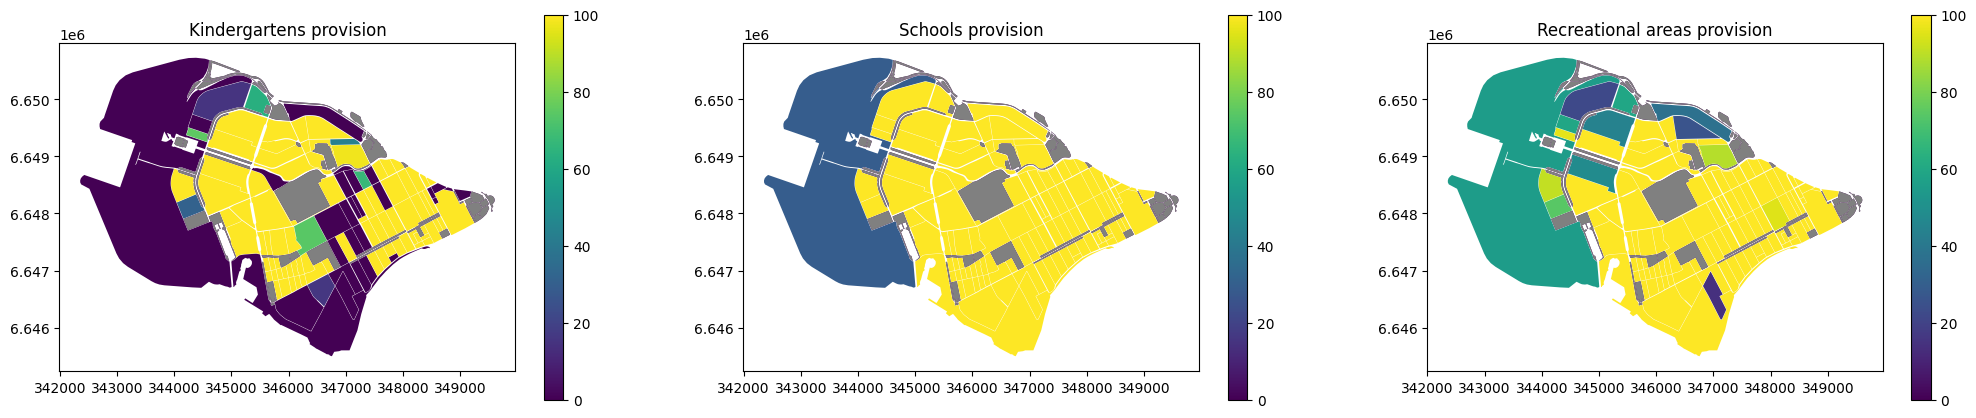

In [7]:
kindergartens_prov = services_prov["kindergartens"]
schools_prov = services_prov["schools"]
recreational_areas_prov = services_prov["recreational_areas"]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 5))
kindergartens_prov.plot(column="provision_kindergartens", legend=True, ax=ax1)
ax1.set_title("Kindergartens provision")
schools_prov.plot(column="provision_schools", legend=True, ax=ax2)
ax2.set_title("Schools provision")
recreational_areas_prov.plot(column="provision_recreational_areas", legend=True, ax=ax3)
ax3.set_title("Recreational areas provision")

kindergartens_prov[kindergartens_prov["population"] == 0].plot(ax=ax1, color="grey", alpha=1)
schools_prov[schools_prov["population"] == 0].plot(ax=ax2, color="grey", alpha=1)
recreational_areas_prov[recreational_areas_prov["population"] == 0].plot(ax=ax3, color="grey", alpha=1)

plt.show()

#### Selected area of the city to which the new parameters will be modelled

In [8]:
try:
    display(polygon.explore())
except:
    print("Install additional packages to get an interactive map: `pip install folium matplotlib mapclassify`")
    display(Image(filename="../img/polygon.png", embed=True))

In [9]:
block = balance_data(
    gdf=city_model.blocks_aggregated_info,
    polygon=polygon,
    school=services_prov["schools"],
    kindergarten=services_prov["kindergartens"],
    greening=services_prov["recreational_areas"],
)

In [10]:
markdown_table = "\n".join(
    (
        "| Option | Techno-economic indicator |",
        "| --- | --- |",
        "\n".join(f"| {key} | {round(value)} |" for key, value in block.items()),
    )
)

pandas_to_markdown(pd.Series(block, name="Option"), "Teckno-economic indicator")

| Option | Teckno-economic indicator |
| --- | --- |
| block_id | 24 |
| area | 40 |
| current_living_area | 5 |
| current_industrial_area | 1 |
| current_population | 14424 |
| current_green_area | 1 |
| floors | 4 |
| population_unprov_schools | 0 |
| population_unprov_kindergartens | 743 |
| population_unprov_recreational_areas | 11161 |

#### Modelling of new parameters for the selected area with maximisation of the number of inhabitants

In [11]:
mp = MasterPlan(
    area=block["area"],
    current_living_area=block["current_living_area"],
    current_industrial_area=block["current_industrial_area"],
    current_population=block["current_population"],
    current_green_area=block["current_green_area"],
    current_unprov_schoolkids=block["population_unprov_schools"],
    current_unprov_kids=block["population_unprov_kindergartens"],
    current_unprov_green_population=block["population_unprov_recreational_areas"],
)

updated_block = mp.optimal_solution_indicators()
updated_block["block_id"] = 24

#### Modelled block transformation requirements

In [12]:
markdown_table = "\n".join(
    (
        "| Option | Techno-economic indicator |\n| --- | --- |",
        "\n".join(f"| {key} | {round(value)} |" for key, value in updated_block.items()),
    )
)

# Markdown(markdown_table)
pandas_to_markdown(pd.Series(updated_block, name="Option"))

| Option | value |
| --- | --- |
| area | 40 |
| population | 14789 |
| b | 30 |
| green_coef_G | 6 |
| living_area | 6 |
| schools_area | 0 |
| schools_capacity | 0 |
| kindergartens_area | 0 |
| kindergartens_capacity | 0 |
| green_area | 8 |
| G_min_capacity | 13272 |
| G_max_capacity | 6636 |
| green_coef_G_capacity | 13272 |
| op_area | 0 |
| parking1_area | 0 |
| parking2_area | 0 |
| block_id | 24 |

In [13]:
updated_block_2 = {'area': 39.81881724414382,
 'population': 30000.0,
 'b': 29.694473966641496,
 'green_coef_G': 6.000675103622856,
 'living_area': 16.759779143393366,
 'schools_area': 1.3,
 'schools_capacity': 400.0,
 'kindergartens_area': 0,
 'kindergartens_capacity': 300,
 'green_area': 3.423267273524289,
 'G_min_capacity': 5705.445455873815,
 'G_max_capacity': 2852.7227279369076,
 'green_coef_G_capacity': 5704.8035669478595,
 'op_area': 0.011877,
 'parking1_area': 2.993004,
 'parking2_area': 2.909865,
 'block_id': 197}

In [14]:
# Example of changing several quarters
updated_block_dict = {}
updated_block_dict[1] = updated_block
updated_block_dict[2] = updated_block_2



#### Making changes based on requirements in the data model

In [15]:
services_graph = nx.Graph()
for service_type in services.keys():
    service_graph = DataGetter().prepare_graph(
        blocks=city_model.city_blocks,
        service_type=service_type,
        buildings=city_model.buildings,
        service_gdf=city_model.services_gdfs[service_type],
        updated_block_info=updated_block_dict,
        accessibility_matrix=city_model.accessibility_matrix,
        services_graph=services_graph,
    )

city_model.services_graph = services_graph


Iterating blocks to prepare graph:   0%|          | 0/29 [00:00<?, ?it/s]

Iterating blocks to prepare graph:   0%|          | 0/33 [00:00<?, ?it/s]

Iterating blocks to prepare graph:   0%|          | 0/152 [00:00<?, ?it/s]

#### Recalculating the provision of services to blocks

In [16]:
services_prov_nev = {}
for service_type in services.keys():
    provision = ProvisionModel(city_model=city_model, service_name=service_type)
    services_prov_nev[service_type] = provision.run()

Number of blocks with service: schools: 29
Number of residential blocks: 114
Number of blocks total: 199
Number of blocks with an error: 0

Number of blocks with service: kindergartens: 33
Number of residential blocks: 114
Number of blocks total: 199
Number of blocks with an error: 0

Number of blocks with service: recreational_areas: 152
Number of residential blocks: 114
Number of blocks total: 199
Number of blocks with an error: 0



#### New service provision visualization

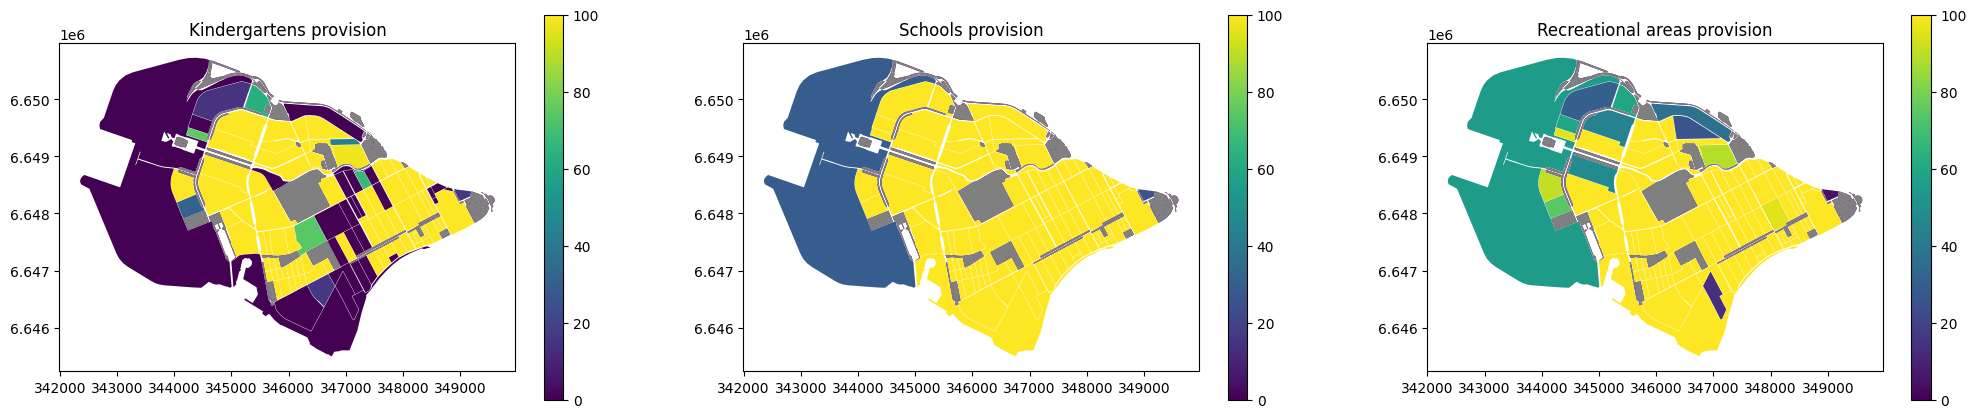

In [17]:
kindergartens_prov_nev = services_prov_nev["kindergartens"]
schools_prov_nev = services_prov_nev["schools"]
recreational_areas_prov_nev = services_prov_nev["recreational_areas"]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 5))
kindergartens_prov_nev.plot(column="provision_kindergartens", legend=True, ax=ax1)
ax1.set_title("Kindergartens provision")
schools_prov_nev.plot(column="provision_schools", legend=True, ax=ax2)
ax2.set_title("Schools provision")
recreational_areas_prov_nev.plot(column="provision_recreational_areas", legend=True, ax=ax3)
ax3.set_title("Recreational areas provision")

kindergartens_prov_nev[kindergartens_prov_nev["population"] == 0].plot(ax=ax1, color="grey", alpha=1)
schools_prov_nev[schools_prov_nev["population"] == 0].plot(ax=ax2, color="grey", alpha=1)
recreational_areas_prov_nev[recreational_areas_prov_nev["population"] == 0].plot(ax=ax3, color="grey", alpha=1)

plt.show()

#### Comparison of service provision before and after the territory change

In [18]:
data = []
before = services_prov["kindergartens"].iloc[24]
after = services_prov_nev["kindergartens"].iloc[24]
for attr in before.index:
    if attr not in ["id", "geometry"]:
        data.append([attr, before[attr], after[attr]])
before = services_prov["schools"].iloc[24]
after = services_prov_nev["schools"].iloc[24]
for attr in before.index:
    if attr not in ["id", "geometry", "population"]:
        data.append([attr, before[attr], after[attr]])
before = services_prov["recreational_areas"].iloc[24]
after = services_prov_nev["recreational_areas"].iloc[24]
for attr in before.index:
    if attr not in ["id", "geometry", "population"]:
        data.append([attr, before[attr], after[attr]])
result = pd.DataFrame(data, columns=["Attribute", "Before", "After"])


pandas_to_markdown(result)

| Attribute | Before | After |
| --- | --- | --- |
| provision_kindergartens | 15 | 15 |
| population_prov_kindergartens | 136 | 136 |
| population_unprov_kindergartens | 743 | 743 |
| population | 14424 | 14424 |
| provision_schools | 100 | 100 |
| population_prov_schools | 1730 | 1730 |
| population_unprov_schools | 0 | 0 |
| provision_recreational_areas | 22 | 30 |
| population_prov_recreational_areas | 3262 | 4368 |
| population_unprov_recreational_areas | 11161 | 10055 |

In [19]:
df_filtered_1 = services_prov["kindergartens"][services_prov["kindergartens"]['provision_kindergartens'] > 0]
kindergartens_all = df_filtered_1['provision_kindergartens'].sum(numeric_only=True) / len(df_filtered_1)

df_filtered_2 = services_prov["schools"][services_prov["schools"]['provision_schools'] > 0]
schools_all = df_filtered_2['provision_schools'].sum(numeric_only=True) / len(df_filtered_2)

df_filtered_3 = services_prov["recreational_areas"][services_prov["recreational_areas"]['provision_recreational_areas'] > 0]
recreational_areas_all = df_filtered_3['provision_recreational_areas'].sum(numeric_only=True) / len(df_filtered_3)
total_prov = (kindergartens_all + schools_all + recreational_areas_all)/3


df_filtered_4 = services_prov_nev["kindergartens"][services_prov_nev["kindergartens"]['provision_kindergartens'] > 0]
kindergartens_all_new = df_filtered_4['provision_kindergartens'].sum(numeric_only=True) / len(df_filtered_4)

df_filtered_5 = services_prov_nev["schools"][services_prov_nev["schools"]['provision_schools'] > 0]
schools_all_new  = df_filtered_5['provision_schools'].sum(numeric_only=True) / len(df_filtered_5)

df_filtered_6 = services_prov_nev["recreational_areas"][services_prov_nev["recreational_areas"]['provision_recreational_areas'] > 0]
recreational_areas_all_new  = df_filtered_6['provision_recreational_areas'].sum(numeric_only=True) / len(df_filtered_6)
total_prov_new  = (kindergartens_all_new  + schools_all_new  + recreational_areas_all_new )/3

print(f"Total provision before {total_prov}")
print(f"Total provision after {total_prov_new}")

Total provision before 96.44417244662043
Total provision after 95.66434765073603
